In [107]:
import os
import numpy as np
import pandas as pd
import compress_json
from glob import glob
from typing import Dict
import matplotlib.pyplot as plt
from humanize import naturaldelta
from tqdm.auto import tqdm, trange
from time import perf_counter, sleep
from sanitize_ml_labels import sanitize_ml_labels
from matplotlib.patches import Ellipse
import re

# Load the data

In [2]:
import humanize 

def xformat_func(value, tick_number):
    if value == 0:
        return "0s"
    if value < 1e-9:
        return r"${:.2f}ps$".format(value * 1e12)
    if value < 1e-6:
        return r"${:.2f}ns$".format(value * 1e9)
    if value < 1e-3:
        return r"${:.2f}\mu s$".format(value * 1e6)
    if value < 1:
        return r"${:.2f}ms$".format(value * 1e3)
    if value < 60:
        return r"${:.2f}s$".format(value)
    if value < 3600:
        return r"${:.2f}m$".format(value / 60)
    
    return r"${:.2f}h$".format(value / 3600)

def yformat_func(value, tick_number):
    return humanize.naturalsize(value * (1000**3))

In [3]:
files = [
    path
    for path in glob('./graphs/results/**/*.csv', recursive=True)
]

In [4]:
reports = pd.DataFrame([
    compress_json.load(report_path)
    for report_path in glob("./graphs/**/report.json", recursive=True)
]).astype({
    "degree_mean":float,
    "density":float,
    "nodes_number":int,
    "undirected_edges_number":int
})

In [17]:
crashed = {}
result = pd.DataFrame()
for file in files:
    # From the path extract the infos
    *_, graph, library, task = file.split("/")
    task = task.split(".")[0]
    # Load the file
    df = pd.read_csv(file, usecols=[0,1], dtype={
        "time":float,
        "memory":float
    })
    df.columns = ["time", "memory"]
    df["name"] = graph
    df["library"] = library
    df["task"] = task
    
    # Check if the experiment was killed
    last_row = df.iloc[-1]
    if last_row.time == 0 and last_row.memory== 0:
        exec_type = "ok"
        df = df.head(-1)
    else:
        crashed[(library, task)] = True
        continue
    
    
    # Update the global results
    result = pd.concat([result, df])

result=result.merge(reports, on=["name"])
max_result = result.groupby(["name", "library", "task"]).max().reset_index()

In [19]:
complete_result = pd.DataFrame()
for file in tqdm(files, desc="Loading benchmarks"):
    # From the path extract the infos
    *_, graph, library, task = file.split("/")
    task = task.split(".")[0]
    # Load the file
    df = pd.read_csv(file, usecols=[0,1], dtype={
        "time":float,
        "memory":float
    })
    df.columns = ["time", "memory"]
    df["name"] = graph
    df["library"] = library
    df["task"] = task    
    
    # Update the global results
    complete_result = pd.concat([complete_result, df])

complete_result=complete_result.merge(reports, on=["name"])
complete_max_result = complete_result.groupby(["name", "library", "task"]).max().reset_index()

In [89]:
from scipy.stats import wilcoxon

libraries = [
    library
    for library in complete_max_result.library.unique()
    # Filtering GraphEmbedding since it does not have yet the necessary datapoints
    if library != "GraphEmbedding"
]

possible_results = ["win", "tie", "loss"]
tasks = ["load_graph", "first_order_walk", "second_order_walk"]
metrics = ["time", "memory"]

win_tie_loss = {
    metric: {}
    for metric in metrics
}

for task in tasks:
    for i, library1 in enumerate(libraries):
        for library2 in libraries[i+1:]:
            for metric in metrics:
                metric1 = complete_max_result[
                    (complete_max_result.library == library1) &
                    (complete_max_result.task == task)
                ].sort_values(by=["nodes_number"])[metric].values.flatten()
                metric2 = complete_max_result[
                    (complete_max_result.library == library2) &
                    (complete_max_result.task == task)
                ].sort_values(by=["nodes_number"])[metric].values.flatten()
                wtl = win_tie_loss[metric]
                if len(metric2)==0:
                    for result in possible_results:
                        key1 = (library2, task, result)
                        wtl[key1] = wtl.get(key1, np.nan)
                if len(metric1)==0:
                    for result in possible_results:
                        key1 = (library1, task, result)
                        wtl[key1] = wtl.get(key1, np.nan)
                if len(metric1)==0 or len(metric2)==0:
                    continue
                _, p_value = wilcoxon(metric1, metric2)
                if p_value < 0.01:
                    if metric1.mean() < metric2.mean():
                        key1 = (library1, task, "win")
                        key2 = (library2, task, "loss")
                        wtl[key1] = wtl.get(key1, 0) + 1
                        wtl[key2] = wtl.get(key2, 0) + 1
                    else: 
                        key1 = (library1, task, "loss")
                        key2 = (library2, task, "win")
                        wtl[key1] = wtl.get(key1, 0) + 1
                        wtl[key2] = wtl.get(key2, 0) + 1
                else:
                    key1 = (library1, task, "tie")
                    key2 = (library2, task, "tie")
                    wtl[key1] = wtl.get(key1, 0) + 1
                    wtl[key2] = wtl.get(key2, 0) + 1

tables = {
    metric: pd.DataFrame({
        (sanitize_ml_labels(metric), sanitize_ml_labels(task), sanitize_ml_labels(result)): {
            library: win_tie_loss[metric].get((library, task, result), 0)
            for library in libraries
        }
        for task in tasks
        for result in possible_results
    })
    for metric in metrics
}

In [90]:
tables["time"]

Time                                       \
                   Load graph           First order walk             
                          Win  Tie Loss              Win  Tie Loss   
CSRgraph                  0.0  0.0  4.0              1.0  1.0  2.0   
EnsmallenGraph            3.0  1.0  0.0              3.0  0.0  1.0   
FastEnsmallenGraph        2.0  0.0  2.0              4.0  0.0  0.0   
Networkx                  1.0  0.0  3.0              NaN  NaN  NaN   
Node2Vec                  NaN  NaN  NaN              0.0  0.0  4.0   
iGraph                    3.0  1.0  0.0              1.0  1.0  2.0   

                                                
                   Second order walk            
                                 Win  Tie Loss  
CSRgraph                         1.0  0.0  2.0  
EnsmallenGraph                   2.0  0.0  1.0  
FastEnsmallenGraph               3.0  0.0  0.0  
Networkx                         NaN  NaN  NaN  
Node2Vec                         0.0  0.0  3.0  
iGraph                           NaN  NaN  NaN

In [91]:
tables["memory"]

Memory                                       \
                   Load graph           First order walk             
                          Win  Tie Loss              Win  Tie Loss   
CSRgraph                  0.0  1.0  3.0              2.0  0.0  2.0   
EnsmallenGraph            3.0  1.0  0.0              3.0  1.0  0.0   
FastEnsmallenGraph        3.0  1.0  0.0              3.0  1.0  0.0   
Networkx                  0.0  1.0  3.0              NaN  NaN  NaN   
Node2Vec                  NaN  NaN  NaN              0.0  0.0  4.0   
iGraph                    2.0  0.0  2.0              1.0  0.0  3.0   

                                                
                   Second order walk            
                                 Win  Tie Loss  
CSRgraph                         1.0  0.0  2.0  
EnsmallenGraph                   2.0  1.0  0.0  
FastEnsmallenGraph               2.0  1.0  0.0  
Networkx                         NaN  NaN  NaN  
Node2Vec                         0.0  0.0  3.0  
iGraph                           NaN  NaN  NaN

In [6]:
result.to_csv("all_reports.csv.gz", index=False)

In [8]:
tasks = ["load_graph", "first_order_walk", "second_order_walk"]

In [9]:
from matplotlib.font_manager import FontProperties
import matplotlib.patheffects as PathEffects
fp = FontProperties(fname="otfs/Font Awesome 5 Free-Solid-900.otf") 

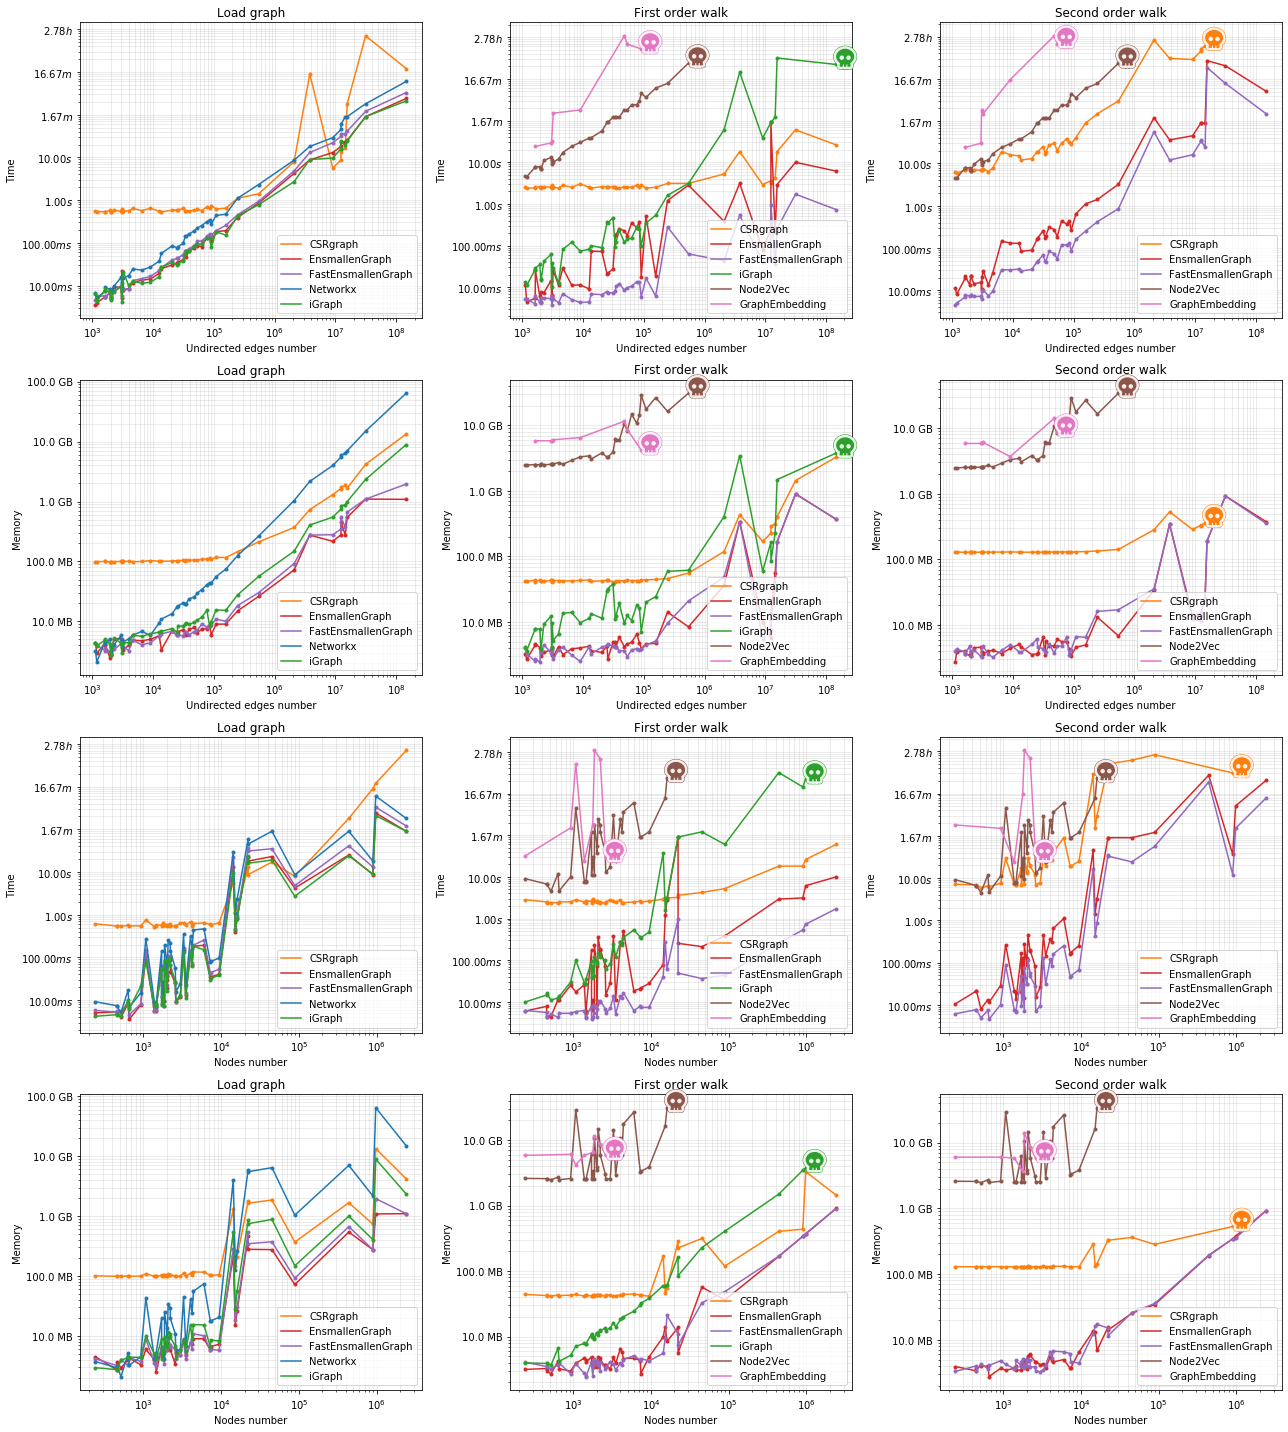

In [22]:
cmap = plt.get_cmap("tab10")
colors = dict(list(zip(result.library.unique(), cmap.colors)))
graphs = max_result.name.unique()
libraries = max_result.library.unique()

fig, axes = plt.subplots(ncols=len(tasks), nrows=4, figsize=(6*len(tasks), 20), squeeze=False)

for library in libraries:
    for i, task in enumerate(tasks):
        data = max_result[
            (max_result.library == library) &
            (max_result.task == task)
        ]
        if data.empty:
            continue
        pos = 0
        for k, number in enumerate(("undirected_edges_number", "nodes_number")):
            for j, (column, format_func) in enumerate((("time", xformat_func), ("memory", yformat_func))):
                axis = axes[pos, i]
                pos+=1
                axis.grid(True, which="both", ls="-", alpha=0.3)
                sorted_data = data.sort_values(by=[number])
                axis.plot(sorted_data[number], sorted_data[column], label=library, c=colors[library])
                axis.plot(sorted_data[number], sorted_data[column], '.', c=colors[library])
                if (library, task) in crashed:
                    x, y = sorted_data.iloc[-1][[number, column]].values
                    txt = axis.text(
                        x,
                        y,
                        "\uf54c",
                        c=colors[library],
                        fontproperties=fp,
                        fontsize=18
                    )
                    txt.set_path_effects([
                        PathEffects.withStroke(
                            linewidth=6,
                            foreground=colors[library],
                        ),
                        PathEffects.withStroke(
                            linewidth=5,
                            foreground='w',
                            alpha=0.9
                        )
                    ])
                axis.set_ylabel(sanitize_ml_labels(column))
                axis.set_xlabel(sanitize_ml_labels(number))
                axis.set_xscale("log")
                axis.set_yscale("log")
                axis.set_title(sanitize_ml_labels(task))
                axis.yaxis.set_major_formatter(plt.FuncFormatter(format_func))
                axis.legend(loc="lower right")
fig.tight_layout()
plt.show()

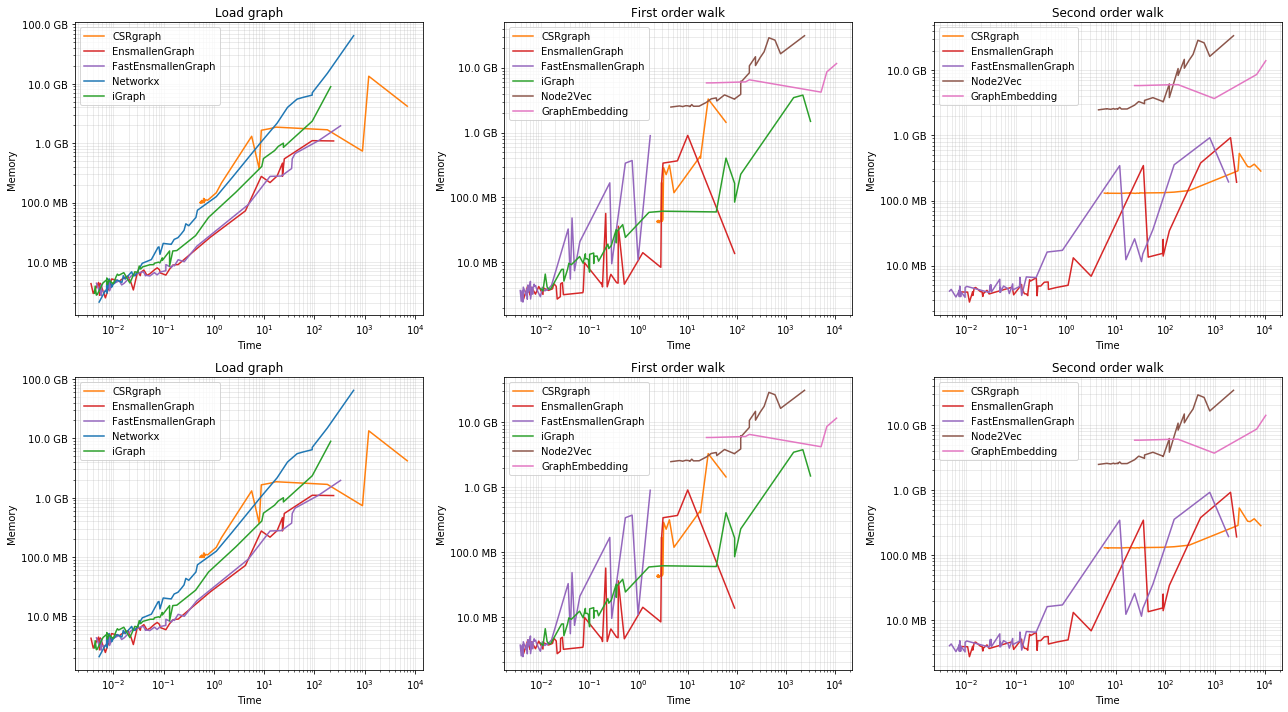

In [11]:
cmap = plt.get_cmap("tab10")
colors = dict(list(zip(result.library.unique(), cmap.colors)))
graphs = max_result.name.unique()
libraries = max_result.library.unique()

fig, axes = plt.subplots(ncols=len(tasks), nrows=2, figsize=(6*len(tasks), 10), squeeze=False)

for library in libraries:
    for i, task in enumerate(tasks):
        data = max_result[
            (max_result.library == library) &
            (max_result.task == task)
        ]
        if data.empty:
            continue
        for k, number in enumerate(("undirected_edges_number", "nodes_number")):
            axis = axes[k, i]
            axis.grid(True, which="both", ls="-", alpha=0.3)
            sorted_data = data.sort_values(by=["time"])
            axis.plot(sorted_data["time"], sorted_data["memory"], label=library, c=colors[library])
            axis.set_ylabel(sanitize_ml_labels("Memory"))
            axis.set_xlabel(sanitize_ml_labels("Time"))
            axis.set_xscale("log")
            axis.set_yscale("log")
            axis.set_title(sanitize_ml_labels(task))
            axis.yaxis.set_major_formatter(plt.FuncFormatter(format_func))
            axis.legend()
fig.tight_layout()
plt.show()

### Plot RAM over time for each task and each graph

In [12]:
def legend_without_duplicate_labels(fig, axes, **kwargs):
    labels_set = set()
    uniques = []
    for row in axes:
        for ax in row:
            handles, labels = ax.get_legend_handles_labels()
            axis_unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
            for (h, l) in axis_unique:
                if l not in labels_set:
                    labels_set.add(l)
                    uniques.append((h, l))
    ax.legend(*zip(*uniques), **kwargs)

NameError: name 'execs_type' is not defined

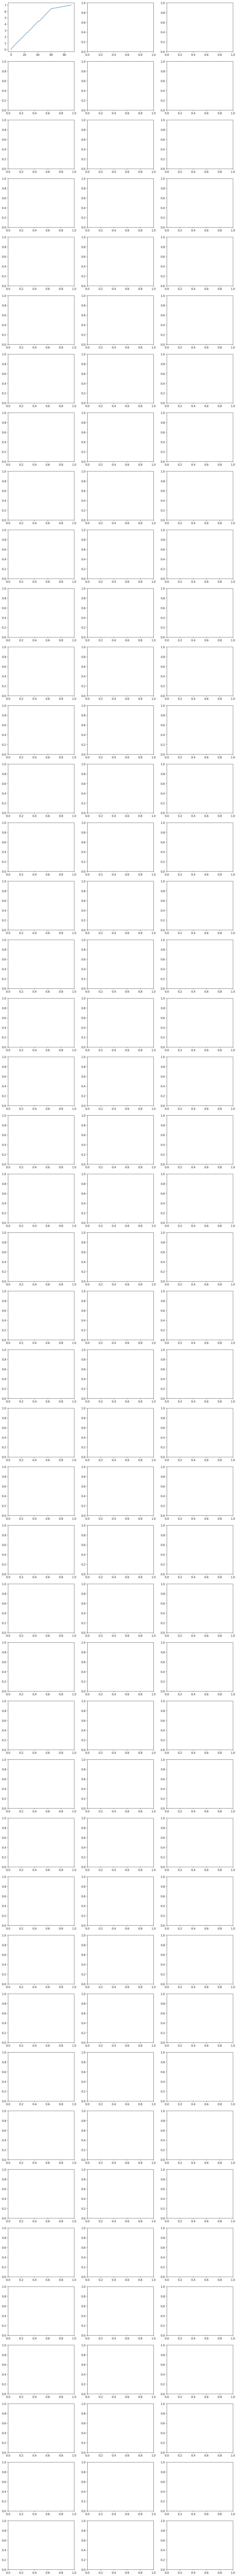

In [13]:
ncols=len(result.task.unique())
nrows=len(result.name.unique())
    

for log in [True, False]:
    fig, axes = plt.subplots(
        dpi=150,
        ncols=ncols,
        nrows=nrows,
        squeeze=False,
        figsize=(5*ncols, 4*nrows)
    )
    for graph, sub_axes in zip(result.name.unique(), axes):
        for task, axis in zip(tasks, sub_axes):
            all_data = result[(result.name==graph) & (result.task==task)]
            max_y = 10**np.ceil(np.log10(all_data.memory.max()))
            min_y = all_data.memory.min()
            if min_y < 0.0001:
                min_y = 0.0001
                
            min_y = 10**np.floor(np.log10(min_y))
            max_x = all_data.time.max()
            min_x = all_data.time.min()
            for library in result.library.unique():
                # get the data for this triple (graph, task, library)
                filtered = all_data[(all_data.library==library)]
                if len(filtered):
                    # Plot the graph
                    axis.plot(filtered.time, filtered.memory, label=sanitize_ml_labels(library), c=colors[library])
                    x, y = filtered.time.iloc[-1], filtered.memory.iloc[-1]
                    # add the termination marker
                    exec_type = execs_type[graph][library][task]
                    if exec_type == "killed":
                        axis.plot([x], [y], marker="x", c=colors[library], markersize=10)
                    elif exec_type == "exception":
                        axis.plot([x], [y], marker="^", c=colors[library])
                    else:
                        axis.plot([x], [y], marker=".", c=colors[library])
                    # Draw the finish line
                    axis.plot([x, x], [min_y, y], "--", alpha=0.5, c=colors[library])
                    axis.plot([min_x, x], [y, y], "--", alpha=0.5, c=colors[library])
            if log:                    
                if not (np.isnan(min_y) or np.isnan(max_y)):
                    axis.set_ylim([min_y, max_y*1.1])
                axis.set_yscale('log')
                axis.set_xscale('log')
                axis.grid(True, which="both", ls="-", alpha=0.3)
            
            axis.set_xlabel("Time")
            axis.set_ylabel("RAM used")
            axis.xaxis.set_tick_params(rotation=-20)
            axis.xaxis.set_major_formatter(plt.FuncFormatter(xformat_func))
            axis.yaxis.set_major_formatter(plt.FuncFormatter(yformat_func))
            axis.set_title("{graph}\n{task}".format(
                graph=graph,
                task=sanitize_ml_labels(task)
            ))
            
                
    legend_without_duplicate_labels(fig, axes, title='Legend', bbox_to_anchor=(1.05, 1), loc='upper left')
    fig.tight_layout()
    fig.set_facecolor('w')

In [152]:
textual_reports = {
    report_path.split("/")[2]: open(report_path, "r").read()
    for report_path in glob("./graphs/**/report.txt", recursive=True)
}

In [153]:
numbers_pattern = re.compile("\d+(?:\.\d)*\d*")
for graph, text in textual_reports.items():
    for number in sorted(re.findall(numbers_pattern, text),  reverse=True):
        textual_reports[graph] = textual_reports[graph].replace(
            " {}".format(number),
            " \({}\)".format(number)
        )

In [157]:
with open("reports.txt", "w") as f:
    for graph, text in textual_reports.items():
        corrected = graph.replace("_", "\_").capitalize()
        f.write("\\subsection{{{graph}}}\n".format(graph=corrected))
        f.write(text.replace("_", "\_"))
        f.write("\n\n")